# Get Best Run

(good link in general) also incorrect false negative?
https://neuroglancer-demo.appspot.com/#!gs://flyem-user-links/short/2023-10-02.154327.json

grace annotated 4 new validation regions: https://cell-map.slack.com/archives/C04N9JUFQK1/p1695934591940359, so will use these

we will use her initial large "validation region" as testing region

annotations_20230929_115330.csv is validation region 2

annotations_20230929_115745.csv is validation region 3

annotations_20230929_115914.csv is validation regions 4 and 5


In [ ]:
import numpy as np

a = np.array([-0.3, 0.4, 1.0, 244.5, 244.4, 255]).astype(np.uint8)
print(a)

In [2]:
import pandas as pd

original_annotations = pd.read_csv("../preprocessing/annotations_20230510_114340.csv")
validation_region_1 = pd.read_csv("../preprocessing/annotations_20230829_173628.csv")
validation_region_2 = pd.read_csv("../preprocessing/annotations_20230929_115330.csv")
validation_region_3 = pd.read_csv("../preprocessing/annotations_20230929_115745.csv")
validation_region_4_and_5 = pd.read_csv(
    "../preprocessing/annotations_20230929_115914.csv"
)
print(
    f"all annotations: {len(original_annotations) + len(validation_region_1) + len(validation_region_2) + len(validation_region_3)+ len(validation_region_4_and_5)}"
)
print(
    f"all annotations assuming region 1 is used for test: {len(original_annotations) + len(validation_region_2) + len(validation_region_3) + len(validation_region_4_and_5)}"
)  # if use validation 1 as test

all annotations: 4429
all annotations assuming region 1 is used for test: 3455


In [9]:
import pandas as pd
import numpy as np
df = pd.read_csv("../preprocessing/annotations/jrc_22ak351-leaf-3m/annotations_20230510_114340.csv")

pd_starts = np.array([df["start x (nm)"], df["start y (nm)"], df["start z (nm)"]]).T
pd_ends = np.array([df["end x (nm)"], df["end y (nm)"], df["end z (nm)"]]).T

np.linalg.norm(pd_starts-pd_ends,axis=1).mean()

190.6893146663395

## min volume

In [5]:
import pandas as pd

df = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/leaf-gall/jrc_22ak351-leaf-3m/plasmodesmata_as_cylinders.csv"
)
print(df["Volume (nm^3)"].min() / (8**3))

358.0


In [ ]:
import numpy as np

df = validation_region_4_and_5

pd_starts = np.array([df["start x (nm)"], df["start y (nm)"], df["start z (nm)"]]).T
pd_ends = np.array([df["end x (nm)"], df["end y (nm)"], df["end z (nm)"]]).T
pd_centers = np.array(
    list(map(tuple, np.round(((pd_starts + pd_ends) / 2)).astype(int)))
)

in_box_5 = (
    (pd_centers[:, 0] <= 126598)
    & (pd_centers[:, 0] >= 118478)
    & (pd_centers[:, 1] <= 38009)
    & (pd_centers[:, 1] >= 30502)
    & (pd_centers[:, 2] <= 50384)
    & (pd_centers[:, 2] >= 34005)
)

In [ ]:
print(
    len(original_annotations)
    + len(validation_region_4_and_5)
    + len(validation_region_1)
)

In [ ]:
import json
from dacapo.store.create_store import (
    create_config_store,
)
from dacapo.experiments import Run
import matplotlib.pyplot as plt
import pandas as pd
import os

df = pd.DataFrame(
    columns=[
        "run",
        "iteration",
        "parameter",
        "full_path",
        "rand_voi",
        "rand_voi_bkgd",
        "detection_f1",
        "detection_iou_f1",
        "detection_avg_iou",
        "detection_iou_avg_iou",
    ]
)

base_dir = "/nrs/cellmap/ackermand/validation_inference/"
for run_name in os.listdir(base_dir):
    for iteration in range(5000, 200000 + 1, 5000):
        for idx, bias in enumerate([0.1, 0.25, 0.5, 0.75, 0.9]):
            parameter = f"WatershedPostProcessorParameters(id={idx}, bias={bias})"
            dir_name = f"/nrs/cellmap/ackermand/validation_inference/{run_name}/processed.n5/iteration_{iteration}/{parameter}"
            file_name = f"{dir_name}/attributes.json"
            try:
                with open(file_name) as f:
                    data = json.load(f)
                detection = data["detection"]
                f1 = (
                    2
                    * detection["tp"]
                    / (2 * detection["tp"] + detection["fp"] + detection["fn"])
                )
                detection_iou = data["detection_iou"]
                f1_iou = (
                    2
                    * detection_iou["tp"]
                    / (
                        2 * detection_iou["tp"]
                        + detection_iou["fp"]
                        + detection_iou["fn"]
                    )
                )
                row = [
                    run_name,
                    iteration,
                    parameter,
                    dir_name,
                    data["rand_voi"],
                    data["rand_voi_include_background"],
                    f1,
                    f1_iou,
                    detection["avg_iou"],
                    detection_iou["avg_iou"],
                ]
                df.loc[len(df.index)] = row
            except:
                pass
                # print(run_name,iteration)

In [ ]:
removed_dummy = df[df["run"].str.contains("removed_dummy")]
f1_max = max(
    removed_dummy["detection_f1"].max(), removed_dummy["detection_iou_f1"].max()
)
df_maxs = removed_dummy[
    (removed_dummy["detection_f1"] == f1_max)
    | (removed_dummy["detection_iou_f1"] == f1_max)
]
print(f1_max, df_maxs["full_path"].values)

In [ ]:
detection_iou

# Check f1 score in new validation region

In [1]:
from funlib.persistence import open_ds
from funlib.geometry import Roi

roi = Roi((19952, 9736, 153344), (13464, 14064, 15104))
best = open_ds(
    "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    "processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
)
gt = open_ds(
    "/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
    "larger_validation_crop",
)
best = best.to_ndarray(roi)
gt = gt.to_ndarray(roi)

In [14]:
import dask
import dask.array as da
import numpy as np
import dask.diagnostics

# target array to be processed block-by-block
# use `da.overlap.overlap` for overlapped blocks
gt_da = da.random.randint(low=1, high=10, size=(4, 4), dtype=int, chunks=2)
test_da = da.random.randint(low=1, high=10, size=(4, 4), dtype=int, chunks=2)


# function that returns a python dictionary
def get_overlap_dict(gt, test):
    out_dict = {}
    gt_ids = np.unique(gt)
    for gt_id in gt_ids:
        if gt_id > 0:
            test_ids, test_counts = np.unique(test[gt == gt_id], return_counts=True)
            nonzeros = test_ids > 0
            out_dict[gt_id] = [
                test_ids[nonzeros],
                test_counts[nonzeros],
            ]
    return out_dict


# list comprehension to iterate over the blocks, lazily
delayed_result = [
    dask.delayed(get_overlap_dict)(gt_block, test_block)
    for (gt_block, test_block) in zip(gt_da.blocks, test_da.blocks)
]

result = dask.delayed(list)(delayed_result)
with dask.diagnostics.ProgressBar():
    print(result.compute())

[########################################] | 100% Completed | 104.62 ms
[{1: [array([2, 8]), array([1, 1])], 2: [array([3, 4, 8]), array([1, 1, 1])], 3: [array([4]), array([1])], 5: [array([5]), array([1])], 9: [array([3]), array([1])]}, {1: [array([5, 7]), array([1, 1])], 2: [array([3, 9]), array([1, 2])], 6: [array([3]), array([1])], 7: [array([5]), array([1])], 9: [array([4]), array([1])]}]


In [1]:
import dask.diagnostics
import dask.array as da
from dask.distributed import Client, LocalCluster
import numpy as np
from scipy.ndimage import binary_erosion
import socket
import itertools
from funlib.persistence import open_ds
from funlib.geometry import Roi
import itertools

# target array to be processed block-by-block
# use `da.overlap.overlap` for overlapped blocks
with LocalCluster(n_workers=8, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        print(
            f'Click here to monitor job: {client.dashboard_link.replace("127.0.0.1", socket.gethostname())}'
        )

        roi = Roi((19952, 9736, 153344), (13464, 14064, 15104)).snap_to_grid((8, 8, 8))
        start_original = np.array(roi.begin / 8).astype(int)
        end_original = np.array(roi.end / 8).astype(int)

        # need to snap to 256 since we are using that for chunk size and because chunks start at 0,0,0
        # in voxels
        roi = roi.snap_to_grid((256 * 8, 256 * 8, 256 * 8))

        # start_prediction_mask = np.array([22400.0, 12800.0, 0.0], dtype=int) / 128
        # prediction_mask_da = da.from_zarr(
        #    "/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
        #    "jrc_22ak351-leaf-3m",
        #    chunks=(16, 16, 16),
        # )
        # prediction_mask_da = da.pad(
        #     prediction_mask_da,
        #     [(start_prediction_mask[i] - start[i], 0) for i in range(3)],
        #     mode="constant",
        #     constant_values=0,
        # )

        prediction_mask_da = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
            "jrc_22ak351-leaf-3m",
            chunks=(128, 128, 128),
        )

        start_prediction = np.array(roi.begin / 128).astype(int)
        end_prediction = np.array(roi.end / 128).astype(int)
        prediction_mask_da = prediction_mask_da[
            start_prediction[0] : end_prediction[0],
            start_prediction[1] : end_prediction[1],
            start_prediction[2] : end_prediction[2],
        ]
        prediction_mask_da = (
            prediction_mask_da.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
        )
        prediction_mask_da = prediction_mask_da.rechunk((256, 256, 256))

        start = np.array(roi.begin / 8).astype(int)
        end = np.array(roi.end / 8).astype(int)
        test_da = da.from_zarr(
            "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
            "processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
            chunks=(256, 256, 256),
        )

        test_da = da.pad(
            test_da,
            [
                (start_original[i] - start[i], end[i] - end_original[i])
                for i in range(3)
            ],
            mode="constant",
            constant_values=0,
        )
        test_da = test_da.rechunk((256, 256, 256))

        gt_da = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
            "larger_validation_crop",
            chunks=(256, 256, 256),
        )
        gt_da = gt_da[
            start[0] : end[0],
            start[1] : end[1],
            start[2] : end[2],
        ]

        # function that returns a python dictionary
        def get_overlap_dict(true_components, test_components, prediction_mask):
            out_dict = {}
            # taken from funlib.evaluate detection
            # change logical_and to logical_or since we want total counts
            # prediction_mask = (
            #     prediction_mask.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
            # )
            test_components = np.multiply(test_components, prediction_mask)

            # NOTE: had to chnage logical_and to logical_or since we are doing this in chunks
            # and want to make sure we have all our ids for downstream processing
            both_fg_mask = np.logical_or(true_components > 0, test_components > 0)
            both_fg_true = true_components[both_fg_mask].ravel()
            both_fg_test = test_components[both_fg_mask].ravel()
            if both_fg_true.size > 0:
                pairs, counts = np.unique(
                    np.array([both_fg_true, both_fg_test]), axis=1, return_counts=True
                )

                for gt_id, test_id, count in zip(pairs[0], pairs[1], counts):
                    out_dict[(gt_id, test_id)] = count
                return out_dict

    # list comprehension to iterate over the blocks, lazily
    delayed_result = [
        dask.delayed(get_overlap_dict)(
            gt_da.blocks[inds],
            test_da.blocks[inds],
            prediction_mask_da.blocks[
                inds
            ],  # tuple([int(ind // 16) for ind in inds])],
        )
        for inds in itertools.product(*map(range, gt_da.blocks.shape))
    ]

    result = dask.delayed(list)(delayed_result)
    with dask.diagnostics.ProgressBar():
        res = result.compute()

import pickle

with open("validation_processing_result.pickle", "wb") as handle:
    pickle.dump(res, handle, protocol=pickle.HIGHEST_PROTOCOL)

Click here to monitor job: http://ackermand-ws2:8787/status
[########################################] | 100% Completed | 203.75 s


## attempt daisy implementation

In [1]:
import daisy
from funlib.persistence import Array, open_ds
from funlib.geometry import Roi, Coordinate
import zarr
import numpy as np
import numcodecs
import tempfile
import pickle
import os


# function that returns a python dictionary
def get_overlap_dict(
    block: daisy.Block,
    gt_array: Array,
    test_array: Array,
    mask_array: Array,
    tmpdirname,
):
    _, block_id = block.block_id
    gt_block = gt_array.to_ndarray(block.read_roi, fill_value=0)
    test_block = test_array.to_ndarray(block.read_roi, fill_value=0)

    mask_roi = block.read_roi.snap_to_grid((128, 128, 128))
    mask_block = mask_array.to_ndarray(mask_roi)
    mask_block = mask_block.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
    mask_begin_voxels = (block.read_roi.begin - mask_roi.begin) / 8
    mask_end_voxels = mask_begin_voxels + Coordinate(gt_block.shape)
    mask_block = mask_block[
        mask_begin_voxels[0] : mask_end_voxels[0],
        mask_begin_voxels[1] : mask_end_voxels[1],
        mask_begin_voxels[2] : mask_end_voxels[2],
    ]

    test_block = np.multiply(test_block, mask_block)

    out_dict = {}
    # taken from funlib.evaluate detection
    # change logical_and to logical_or since we want total counts
    # prediction_mask = (
    #     prediction_mask.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
    # )

    # test_components = np.multiply(test_components, prediction_mask)

    # NOTE: had to chnage logical_and to logical_or since we are doing this in chunks
    # and want to make sure we have all our ids for downstream processing
    both_fg_mask = np.logical_or(gt_block > 0, test_block > 0)
    both_fg_true = gt_block[both_fg_mask].ravel()
    both_fg_test = test_block[both_fg_mask].ravel()
    if both_fg_true.size > 0:
        pairs, counts = np.unique(
            np.array([both_fg_true, both_fg_test]), axis=1, return_counts=True
        )

        for gt_id, test_id, count in zip(pairs[0], pairs[1], counts):
            out_dict[(gt_id, test_id)] = count

    with open(f"{tmpdirname}/block_{block_id}.pkl", "wb") as fp:
        pickle.dump(out_dict, fp)


def combine_block_dicts(tmpdirname):
    gt_test_counts = {}
    test_ids = {0}
    gt_ids = {0}
    for block_filename in os.listdir(tmpdirname):
        with open(f"{tmpdirname}/{block_filename}", "rb") as f:
            block_dict = pickle.load(f)
            if block_dict:
                for (gt_id, test_id), v in block_dict.items():
                    gt_ids.add(gt_id)
                    test_ids.add(test_id)
                    gt_test_counts[(gt_id, test_id)] = (
                        gt_test_counts.get((gt_id, test_id), 0) + v
                    )

    # vs = np.array(list(test_id_counts.values()))

    test_id_renumbering = {test_id: i for i, test_id in enumerate(test_ids)}
    gt_id_renumbering = {gt_id: i for i, gt_id in enumerate(gt_ids)}
    # n_test = len(test_ids) - 1
    # n_gt = len(gt_ids) - 1
    gt_test_overlaps = np.zeros(
        (len(gt_id_renumbering), len(test_id_renumbering)), dtype=np.int64
    )
    for (gt_id, test_id), v in gt_test_counts.items():
        # TODO: Does it matter the order? In Funke lab stuff it is test, gt...
        gt_test_overlaps[gt_id_renumbering[gt_id], test_id_renumbering[test_id]] = v

    with open(f"testing.pkl", "wb") as fp:
        pickle.dump(
            {
                "test_gt_counts": gt_test_counts,
                "gt_id_renumbering": gt_id_renumbering,
                "test_id_renumbering": test_id_renumbering,
                "gt_test_overlaps": gt_test_overlaps,
            },
            fp,
        )


with tempfile.TemporaryDirectory() as tmpdirname:
    total_roi = Roi((19952, 9736, 153344), (13464, 14064, 15104)).snap_to_grid(
        (8, 8, 8)
    )

    test_array: Array = open_ds(
        filename="/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
        ds_name="processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
    )
    gt_array: Array = open_ds(
        filename="/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
        ds_name="larger_validation_crop",
    )
    mask_array: Array = open_ds(
        filename="/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
        ds_name="jrc_22ak351-leaf-3m",
    )

    read_write_roi: Roi = Roi((0, 0, 0), gt_array.chunk_shape * gt_array.voxel_size)

    task = daisy.Task(
        total_roi=total_roi,
        read_roi=read_write_roi,
        write_roi=read_write_roi,
        process_function=lambda b: get_overlap_dict(
            b, gt_array, test_array, mask_array, tmpdirname
        ),
        num_workers=10,
        task_id="block_processing",
    )
    # add export of scores
    daisy.run_blockwise([task])
    combine_block_dicts(tmpdirname)

block_processing ▶:   0%|          | 0/2366 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task block_processing:

    num blocks : 2366
    completed ✔: 2366 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully


In [2]:
mask = open_ds(
    filename="/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
    ds_name="jrc_22ak351-leaf-3m",
)
mask.voxel_size

(128, 128, 128)

In [49]:
import pickle
import scipy


def get_matches(array_to_optimize):
    gt_idxs, test_idxs = scipy.optimize.linear_sum_assignment(
        array_to_optimize, maximize=True
    )
    matches = [
        (gt_idx + 1, test_idx + 1)  # add one for background
        for gt_idx, test_idx in zip(gt_idxs, test_idxs)
        if array_to_optimize[gt_idx, test_idx] > 0
    ]
    return matches


def get_f1_score(gt_test_overlaps):
    gt_test_overlaps_without_background = gt_test_overlaps[1:, 1:]
    matches = get_matches(gt_test_overlaps_without_background)
    n_gt, n_test = gt_test_overlaps_without_background.shape
    tp = len(matches)
    fp = n_test - tp
    fn = n_gt - tp

    iou = get_iou(gt_test_overlaps)
    average_iou = np.mean(
        [iou[gt_idx - 1, test_idx - 1] for (gt_idx, test_idx) in matches]
    )

    return {
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "f1_score": tp / (tp + 0.5 * (fp + fn)),
        "iou": average_iou,
    }


def get_iou(gt_test_overlaps):
    # iou score
    gt_test_overlaps_without_background = gt_test_overlaps[1:, 1:]
    gt_volumes = np.sum(gt_test_overlaps, axis=1)[1:]  # ignore background
    test_volumes = np.sum(gt_test_overlaps, axis=0)[1:]  # ignore background
    # need to subtract overlap otherwise double count it
    union = (
        np.expand_dims(gt_volumes, 1) + np.expand_dims(test_volumes, 0)
    ) - gt_test_overlaps_without_background
    iou = gt_test_overlaps_without_background / union
    return iou


def get_iou_score(gt_test_overlaps):
    iou = get_iou(gt_test_overlaps)
    matches = get_matches(iou)
    average_iou = np.mean(
        [iou[gt_idx - 1, test_idx - 1] for (gt_idx, test_idx) in matches]
    )
    return {"iou_score": average_iou, "iou_matches": matches}


def get_scores_new():
    with open("testing.pkl", "rb") as f:
        pkl = pickle.load(f)
    gt_test_overlaps = pkl["gt_test_overlaps"]
    f1_score_dict = get_f1_score(gt_test_overlaps)
    iou_score_dict = get_iou_score(gt_test_overlaps)
    return {"f1_score_info": f1_score_dict, "iou_score_info": iou_score_dict}


def get_scores():
    with open("testing.pkl", "rb") as f:
        pkl = pickle.load(f)
    # f1 score:
    test_id_renumbering = pkl["test_id_renumbering"]
    gt_id_renumbering = pkl["gt_id_renumbering"]
    gt_test_overlaps = pkl["gt_test_overlaps"]

    # f1 score
    # gotta ignore background...
    gt_test_overlaps_without_background = gt_test_overlaps[1:, 1:]
    matches = scipy.optimize.linear_sum_assignment(
        gt_test_overlaps_without_background, maximize=True
    )
    matches = [
        (gt_idx + 1, test_idx + 1)  # add one for background
        for gt_idx, test_idx in zip(matches[0], matches[1])
        if gt_test_overlaps_without_background[gt_idx, test_idx]
        >= 1  # and test_id > 0 and gt_id > 0
    ]

    # subtract 1 for background
    n_test = len(test_id_renumbering) - 1
    n_gt = len(gt_id_renumbering) - 1
    tp = len(matches)
    fp = n_test - tp
    fn = n_gt - tp
    print(tp, fp, fn, tp / (tp + 0.5 * (fp + fn)))

    # iou score
    gt_volumes = np.sum(gt_test_overlaps, axis=1)[1:]  # ignore background
    test_volumes = np.sum(gt_test_overlaps, axis=0)[1:]  # ignore background
    # need to subtract overlap otherwise double count it
    union = (
        np.expand_dims(gt_volumes, 1) + np.expand_dims(test_volumes, 0)
    ) - gt_test_overlaps_without_background
    iou = gt_test_overlaps_without_background / union
    matches = scipy.optimize.linear_sum_assignment(iou, maximize=True)
    matches = [
        (gt_idx + 1, test_idx + 1)  # add one for background
        for gt_idx, test_idx in zip(matches[0], matches[1])
        if gt_test_overlaps_without_background[gt_idx, test_idx]
        >= 1  # and test_id > 0 and gt_id > 0
    ]


get_scores()
get_scores_new()

720 1728 128 0.4368932038834951


{'f1_score_info': {'tp': 720,
  'fp': 1728,
  'fn': 128,
  'f1_score': 0.4368932038834951,
  'iou': 0.3079191096062949},
 'iou_score_info': {'iou_score': 0.30792880535091716,
  'iou_matches': [(2, 1470),
   (3, 2210),
   (6, 2269),
   (8, 1055),
   (9, 1820),
   (10, 274),
   (11, 500),
   (12, 521),
   (13, 699),
   (14, 768),
   (15, 324),
   (16, 613),
   (17, 432),
   (18, 400),
   (19, 142),
   (20, 465),
   (22, 105),
   (23, 585),
   (24, 359),
   (26, 1887),
   (28, 1921),
   (29, 113),
   (30, 134),
   (31, 147),
   (32, 2126),
   (33, 635),
   (34, 615),
   (35, 982),
   (36, 1063),
   (37, 454),
   (38, 1877),
   (39, 809),
   (40, 1858),
   (41, 1380),
   (42, 1788),
   (43, 146),
   (44, 1691),
   (45, 551),
   (46, 629),
   (47, 2377),
   (49, 983),
   (50, 1955),
   (52, 2060),
   (54, 45),
   (57, 112),
   (58, 1891),
   (59, 1854),
   (60, 469),
   (61, 40),
   (62, 1865),
   (63, 1894),
   (64, 1853),
   (65, 1752),
   (66, 1620),
   (67, 1584),
   (68, 1989),
   (69,

In [47]:
import yaml

with open(
    "/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/scorer_yamls/jrc_22ak351-leaf-3m_2023-12-04.yml",
    "r",
) as stream:
    yml = yaml.safe_load(stream)

In [62]:
import datetime
import yaml

with open(
    "/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/scorer_yamls/jrc_22ak351-leaf-3m_2023-12-04.yml",
    "r",
) as stream:
    yml = yaml.safe_load(stream)

iterations_start, iterations_end, iterations_step = yml["iterations"]
test_array_filename = yml["test_array"]["filename"]
date_and_time = datetime.now().strftime(f"%Y%m%d_%H%M%S")

for run in yml["runs"]:
    for iteration in range(iterations_start, iterations_end + 1, iterations_step):
        for roi_name in yml["roi_names"]:
            for postprocessing_suffix in yml["postprocessing_suffixes"]:
                for test_or_validation in ["test", "validation"]:
                    test_array = yml["test_array"]
                    test_array_ds = test_array["ds_base_path"]
                    test_array_ds = f"{test_array_ds}/{run}/{roi_name}.n5/iteration_{iteration}{postprocessing_suffix}"
                    output_directory = f"/nrs/cellmap/ackermand/validation_and_testing_scores/{date_and_time}/{run}/{roi_name}/iteration_{iteration}{postprocessing_suffix}"
                    break
                break
            break
        break
    break

/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5/processed/test/finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0/cyan.n5/iteration_100000_filter_val_0.5_lrb_ratio_-0.08_adj_0.5_lr_-1.2_segs
/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5/processed/test/finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0/cyan.n5/iteration_100000_filter_val_0.5_lrb_ratio_-0.08_adj_0.5_lr_-1.2_segs


In [43]:
import numpy as np

cost = np.array([[0, 0, 0], [0, 33, 5], [5, 0, 0]])
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(cost, maximize=True)
row_ind, col_ind

(array([0, 1, 2]), array([2, 1, 0]))

In [17]:
gt_test_overlaps.shape

NameError: name 'gt_test_overlaps' is not defined

In [4]:
m1 = np.array([[1, 2, 3], [4, 5, 6]])  # 3X2
m2 = np.array([[1], [2]])  # 2X1
m2 + m1

array([[2, 3, 4],
       [6, 7, 8]])

In [ ]:
a = np.arange(25).reshape(5, 5)

In [11]:
a = np.array([[1, 2], [3, 4], [5, 6]])
np.sum(a, axis=0)

array([ 9, 12])

In [18]:
import numpy as np

np.argmax(np.sum(overlaps_without_background > 0, axis=0))

12

In [59]:
matches = scipy.optimize.linear_sum_assignment(overlaps[1:, 1:], maximize=True)
overlaps[matches[0], matches[1]]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
np.unique(overlaps[1:, 1:])

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   11,
         13,   14,   15,   16,   17,   19,   20,   22,   25,   26,   27,
         30,   31,   32,   34,   35,   36,   38,   40,   41,   42,   44,
         45,   46,   47,   50,   56,   57,   59,   64,   66,   72,   75,
         76,   81,   86,   88,   89,   90,   93,   94,   98,   99,  100,
        103,  107,  108,  109,  110,  111,  113,  119,  125,  129,  133,
        134,  143,  149,  153,  156,  168,  170,  173,  178,  187,  188,
        191,  192,  199,  201,  208,  211,  212,  213,  216,  217,  219,
        220,  222,  228,  231,  233,  235,  236,  239,  240,  245,  247,
        257,  260,  262,  263,  271,  273,  275,  277,  278,  285,  290,
        293,  294,  296,  299,  304,  306,  307,  312,  319,  321,  326,
        328,  331,  333,  334,  342,  347,  348,  353,  355,  357,  363,
        374,  377,  378,  381,  382,  384,  385,  388,  394,  395,  396,
        398,  403,  408,  409,  412,  413,  414,  4

In [25]:
len(matches)

0

In [13]:
test_id_renumbering

{0: 0,
 8812232705: 1,
 8812232706: 2,
 8812232707: 3,
 8812232708: 4,
 1879048193: 5,
 1879048194: 6,
 1879048195: 7,
 1879048196: 8,
 111149057: 9,
 111149058: 10,
 226492417: 11,
 1621098497: 12,
 1621098498: 13,
 784334850: 14,
 987758593: 15,
 1621098499: 16,
 987758594: 17,
 987758595: 18,
 15627976706: 19,
 17003708418: 20,
 1621098500: 21,
 3003121667: 22,
 3642753027: 23,
 1287651331: 24,
 1293942787: 25,
 5614075909: 26,
 1568669700: 27,
 1568669701: 28,
 580911108: 29,
 2927624197: 30,
 1568669702: 31,
 15627976705: 32,
 17003708417: 33,
 2575302657: 34,
 1251999750: 35,
 3642753031: 36,
 5614075911: 37,
 1568669703: 38,
 719323143: 39,
 5955911687: 40,
 5614075912: 41,
 1568669704: 42,
 5955911688: 43,
 1086324744: 44,
 1314914311: 45,
 4959764489: 46,
 5614075913: 47,
 6683623433: 48,
 1086324745: 49,
 501219337: 50,
 1568669706: 51,
 6683623434: 52,
 1086324746: 53,
 4441767946: 54,
 501219338: 55,
 3003121666: 56,
 5614075915: 57,
 1568669698: 58,
 1568669707: 59,
 90596

# Find best run by comparing metrics

In [1]:
import json
import yaml
import numpy as np


def update_combined_dict(combined_dict, output_directory, validation_or_test, roi_name):
    output_directory = output_directory.replace(
        "validation_or_test", validation_or_test
    ).replace("roi_name", str(roi_name))
    with open(f"{output_directory}/scores.json") as f:
        roi_dict = json.load(f)
        for k in ["tp_gt_test_id_pairs", "fp_test_ids", "fn_gt_ids"]:
            del roi_dict["f1_score_info"][k]
        combined_dict[roi_name] = roi_dict
    for key in ["fp", "tp", "fn"]:
        combined_dict["combined"][key] += combined_dict[roi_name]["f1_score_info"][key]
    combined_dict["combined"]["average_f1_score"].append(
        combined_dict[roi_name]["f1_score_info"]["f1_score"]
    )


yaml_name = "jrc_22ak351-leaf-3m_2023-12-06"
with open(
    # "/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/metrics_yamls/jrc_22ak351-leaf-3m_2023-12-04.yml",
    f"/groups/cellmap/cellmap/ackermand/Programming/plasmodesmata_dacapo/validation_and_test/yamls/combined_yamls/{yaml_name}.yml",
    "r",
) as stream:
    yml = yaml.safe_load(stream)

dataset = yml["dataset"]
gt_array_filename = yml["gt_array"]["filename"]
gt_array_ds_name = yml["gt_array"]["ds_name"]
mask_array_filename = yml["mask_array"]["filename"]
mask_array_ds_name = yml["mask_array"]["ds_name"]

iterations_start, iterations_end, iterations_step = yml["iterations"]
previous_best_f1_score = -1
count = 0
for run in yml["runs"]:
    for iteration in range(iterations_start, iterations_end + 1, iterations_step):
        for postprocessing_suffix in yml["postprocessing_suffixes"]:
            test_array = yml["test_array"]
            # test_array_filename = f'{test_array["base_filename"]}/processed/validation/{run}/{roi_name}.n5'
            # test_array_ds_name = f"iteration_{iteration}{postprocessing_suffix}"
            # output_directory = f"/nrs/cellmap/ackermand/validation_and_testing_scores/20231204_232852/{validation_or_test}/{run}/{roi_name}/iteration_{iteration}{postprocessing_suffix}"

            # if roi_name == "cyan" and validation_or_test == "validation":
            combined_validation_dict = {
                "combined": {
                    "tp": 0,
                    "fp": 0,
                    "fn": 0,
                    "f1_score": 0,
                    "average_f1_score": [],
                }
            }
            combined_test_dict = {
                "combined": {
                    "tp": 0,
                    "fp": 0,
                    "fn": 0,
                    "f1_score": 0,
                    "average_f1_score": [],
                }
            }
            for roi in yml["rois"]:
                roi_name = roi["name"]
                output_directory = f"/nrs/cellmap/ackermand/validation_and_testing_scores/{yaml_name}/validation_or_test/{run}/roi_name/iteration_{iteration}{postprocessing_suffix}"
                update_combined_dict(
                    combined_validation_dict,
                    output_directory,
                    "validation",
                    roi_name,
                )
                count += 1
                if roi["split_dimension"] is not None:
                    update_combined_dict(
                        combined_test_dict, output_directory, "test", roi_name
                    )
                    count += 1

            combined_validation_dict["combined"]["f1_score"] = combined_validation_dict[
                "combined"
            ]["tp"] / (
                combined_validation_dict["combined"]["tp"]
                + 0.5
                * (
                    combined_validation_dict["combined"]["fp"]
                    + combined_validation_dict["combined"]["fn"]
                )
            )

            combined_test_dict["combined"]["f1_score"] = combined_test_dict["combined"][
                "tp"
            ] / (
                combined_test_dict["combined"]["tp"]
                + 0.5
                * (
                    combined_test_dict["combined"]["fp"]
                    + combined_test_dict["combined"]["fn"]
                )
            )

            combined_validation_dict["combined"]["average_f1_score"] = np.mean(
                combined_validation_dict["combined"]["average_f1_score"]
            )
            combined_test_dict["combined"]["average_f1_score"] = np.mean(
                combined_test_dict["combined"]["average_f1_score"]
            )

            if (
                combined_validation_dict["combined"]["f1_score"]
                >= previous_best_f1_score
            ):
                previous_best_f1_score = combined_validation_dict["combined"][
                    "f1_score"
                ]
                best_combined_validation_dict = combined_validation_dict
                best_combined_test_dict = combined_test_dict
                print(
                    combined_validation_dict["combined"],
                    combined_test_dict["combined"],
                    run,
                    iteration,
                )

{'tp': 543, 'fp': 506, 'fn': 658, 'f1_score': 0.4826666666666667, 'average_f1_score': 0.5356503585471971} {'tp': 705, 'fp': 449, 'fn': 451, 'f1_score': 0.6103896103896104, 'average_f1_score': 0.5827579943762884} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 100000
{'tp': 722, 'fp': 1063, 'fn': 479, 'f1_score': 0.4835900870730074, 'average_f1_score': 0.527193412015262} {'tp': 777, 'fp': 952, 'fn': 379, 'f1_score': 0.5386481802426343, 'average_f1_score': 0.535797834165656} finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0 140000
{'tp': 677, 'fp': 900, 'fn': 524, 'f1_score': 0.48740100791936647, 'average_f1_score': 0.5277175531523643} {'tp': 770, 'fp': 766, 'fn': 386, 'f1_score': 0.5720653789004457, 'average_f1_score': 0.5435632301681438} finetuned_3d_lsdaffs

In [2]:
yml["runs"]

['finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0',
 'finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1',
 'finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__2',
 'finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_removed_dummy_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__0',
 'finetuned_3d_lsdaffs_weight_ratio_0.50_plasmodesmata_pseudorandom_training_centers_maxshift_18_removed_dummy_annotations_unet_default_v2_no_dataset_predictor_node_lr_5E-5__1',
 'finetuned_3d_lsdaffs_weight_ratio_1.00_plasmodesmata_pseudorandom_training_centers_maxshift_18_more_annotations_unet_default_v2_no_data

## original best run score

In [2]:
from funlib.persistence import open_ds, Array
from funlib.geometry import Roi
from utils import *


total_roi = Roi(
    [82304, 22808, 34936][::-1], [3832, 15672, 7328][::-1]
)  # Roi([82304, 22808, 24712][::-1], [3832, 15672, 9064][::-1])

test_array: Array = open_ds(
    filename="/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    ds_name="processed/2023-07-26/plasmodesmata_affs_lsds/0/fragments_relabeled/",
)
gt_array: Array = open_ds(
    filename="/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
    ds_name="plasmodesmata_as_cylinders",
)
mask_array: Array = open_ds(
    filename="/nrs/cellmap/ackermand/cellpose/jrc_22ak351-leaf-3m/cellpose_results.n5",
    ds_name="raw_s4_inverted_cp_masks_from_jeff_inverted",
)

iso = InstanceSegmentationOverlap(gt_array, test_array, mask_array, total_roi=total_roi)
overlap_dict = iso.get_overlap_dict()
iss = InstanceSegmentationScorer(overlap_dict)
print(iss.get_scores())

block_processing ▶:   0%|          | 0/512 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task block_processing:

    num blocks : 512
    completed ✔: 512 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully
{'f1_score_info': {'tp': 91, 'fp': 112, 'fn': 65, 'f1_score': 0.5069637883008357, 'iou': 0.35075486199466865, 'tp_gt_test_id_pairs': [[3072, 405190737932], [3074, 428859195406], [3073, 416911720466], [3075, 416911720463], [3077, 416911720457], [3078, 428859195395], [3080, 428859195398], [3081, 416911720460], [3082, 416911720452], [3083, 428859195397], [3084, 428859195400], [3076, 428859195409], [3085, 405243166727], [3086, 416966246406], [3087, 405241069577], [3088, 416966246402], [3089, 405241069573], [3090, 405241069571], [3092, 416911720451], [3093, 428804669446], [3094, 428804669444], [3095, 428804669443], [3091, 405241069574], [3097, 453318279182], [3098, 440922013698], [3099, 453318279177], [3102, 453318279176], [3103, 453318279178], [3105, 465890705417], [3106, 465890705413], [3107, 4658

In [9]:
pkl_test_gt_counts = pkl["test_gt_counts"]
pkl_test_id_renumbering = pkl["test_id_renumbering"]
pkl_gt_id_renumbering = pkl["gt_id_renumbering"]
pkl_overlaps = pkl["overlaps"]
for (gt_id, test_id), v in pkl_test_gt_counts.items():
    if (
        pkl_overlaps[pkl_test_id_renumbering[test_id], pkl_gt_id_renumbering[gt_id]]
        != overlaps[test_id_renumbering[test_id], gt_id_renumbering[gt_id]]
    ):
        raise Exception(("fail"))
print(
    len(pkl["test_id_renumbering"].keys() & test_id_renumbering.keys()),
    len(test_id_renumbering),
    len(pkl["test_id_renumbering"]),
)
print(
    len(pkl["gt_id_renumbering"].keys() & gt_id_renumbering.keys()),
    len(gt_id_renumbering),
    len(pkl["gt_id_renumbering"]),
)

2449 2449 2449
849 849 849


In [33]:
np.equal(overlaps, pkl_overlaps)

array([[ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       ...,
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True]])

In [52]:
print(
    len(pkl["test_id_renumbering"].keys() & test_id_renumbering.keys()),
    len(test_id_renumbering),
    len(pkl["test_id_renumbering"]),
)

2763 2763 2763


In [ ]:
for (gt_id, test_id), v in test_gt_counts.items():
    pkl["overlaps"][test_id_renumbering[test_id], gt_id_renumbering[gt_id]] = v

In [5]:
from funlib.persistence import Array, open_ds

test_array: Array = open_ds(
    filename="/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    ds_name="processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
)

In [6]:
test_array.roi.begin

(19952, 9736, 153344)

In [21]:
print(u)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

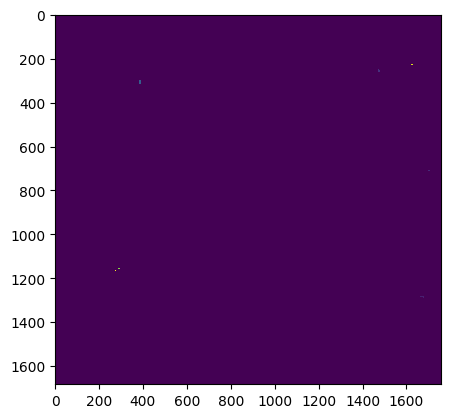

In [47]:
import matplotlib.pyplot as plt

plt.imshow(gt[:, :, 500], interpolation="none")

In [37]:
overlaps = np.load("testing.npz")
overlaps = overlaps["overlaps"]
np.sum(overlaps > 0) - np.sum(overlaps.shape)

826

In [35]:
overlaps.shape

(5129, 849)

In [24]:
import numpy as np
import daisy
from funlib.geometry import Roi
import zarr
from funlib.persistence import Array

shape = 4096000
reduce_shape = shape / 16
block_shape = 1024 * 16

a = Array(
    np.random.random_integers(0, 1000, shape), roi=Roi((0,), shape), voxel_size=(1,)
)
# to parallelize across processes, we need persistent read/write arrays
# we'll use zarr here to do do that
b = zarr.open_array(
    zarr.TempStore(), "w", (shape,), chunks=(block_shape,), dtype=np.int64
)
# output array is wrapped in Array for easy of Roi indexing
b = Array(b, roi=Roi((0,), shape), voxel_size=(1,))
# while using zarr with `Array` can be easier to understand and less error prone, it is not a requirement.
# Here we make a shared memory array for collecting results from different workers
c = np.ones(
    int(shape / reduce_shape)
)  # multiprocessing.Array('Q', range(int(shape/reduce_shape)))


def process_fn_sum_reduce(block):
    a_sub = a[block.write_roi].to_ndarray()
    s = np.sum(a_sub)
    # compute c idx based on block offset and shape
    idx = (block.write_roi.offset / block.write_roi.shape)[0]
    c[idx] = s


total_roi = Roi((0,), shape)  # total ROI to map process over
block_roi = Roi((0,), reduce_shape)  # block ROI for parallel processing
task1 = daisy.Task(
    total_roi=total_roi,
    read_roi=block_roi,
    write_roi=block_roi,
    process_function=process_fn_sum_reduce,
    num_workers=8,
    task_id="sum_reduce",
)
daisy.run_blockwise([task1])
print(c[:])

/tmp/ipykernel_7961/4012258690.py:11: DeprecationWarning: This function is deprecated. Please call randint(0, 1000 + 1) instead
  a = Array(np.random.random_integers(0,1000,shape), roi=Roi((0,), shape), voxel_size=(1,))


sum_reduce ▶:   0%|          | 0/16 [00:00<?, ?blocks/s]


Execution Summary
-----------------

  Task sum_reduce:

    num blocks : 16
    completed ✔: 16 (skipped 0)
    failed    ✗: 0
    orphaned  ∅: 0

    all blocks processed successfully
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
b = zarr.open_array(
    zarr.TempStore(),
    "w",
    (shape,),
    chunks=(block_shape,),
    dtype=object,
    object_codec=numcodecs.JSON(),
)
b[0] = "asdfsaf"

In [ ]:
prediction_mask_da = da.from_zarr(
    "/nrs/cellmap/ackermand/cellmap/leaf-gall/validation_masks.zarr",
    "jrc_22ak351-leaf-3m",
    chunks=(128, 128, 128),
)

start_prediction = np.array(roi.begin / 128).astype(int)
end_prediction = np.array(roi.end / 128).astype(int)
prediction_mask_da = prediction_mask_da[
    start_prediction[0] : end_prediction[0],
    start_prediction[1] : end_prediction[1],
    start_prediction[2] : end_prediction[2],
]
prediction_mask_da = (
    prediction_mask_da.repeat(16, axis=0).repeat(16, axis=1).repeat(16, axis=2)
)
prediction_mask_da = prediction_mask_da.rechunk((256, 256, 256))
prediction_mask_da

In [ ]:
import matplotlib.pyplot as plt

plt.subplots(3, 1, figsize=(20, 12))
plt.subplot(3, 1, 1)
p = prediction_mask_da[:, 1000, :]
p = p.compute()
plt.imshow(p, interpolation="none")

gt = gt_da[:, 1000, :]
gt = gt.compute()
plt.subplot(3, 1, 2)
plt.imshow(gt > 0, interpolation="none")

test = test_da[:, 1000, :]
test = test.compute()
plt.subplot(3, 1, 3)
plt.imshow(test > 0, interpolation="none")

In [20]:
import pickle
import numpy as np


with open("validation_processing_result.pickle", "rb") as f:
    res = pickle.load(f)
test_id_counts = {}
gt_id_counts = {}
test_gt_counts = {}
test_ids = {0}
gt_ids = {0}
for current_dict in res:
    if current_dict:
        for (gt_id, test_id), v in current_dict.items():
            gt_ids.add(gt_id)
            test_ids.add(test_id)
            test_gt_counts[(gt_id, test_id)] = (
                test_gt_counts.get((gt_id, test_id), 0) + v
            )

vs = np.array(list(test_id_counts.values()))
print(np.sum(np.array(list(gt_id_counts.values())) > 0), np.sum(vs > 0))

0 0


In [21]:
test_id_renumbering = {test_id: i for i, test_id in enumerate(test_ids)}
gt_id_renumbering = {gt_id: i for i, gt_id in enumerate(gt_ids)}
n_test = len(test_ids) - 1
n_gt = len(gt_ids) - 1


overlaps = np.zeros((len(test_id_renumbering), len(gt_id_renumbering)), dtype=np.int64)

for (gt_id, test_id), v in test_gt_counts.items():
    overlaps[test_id_renumbering[test_id], gt_id_renumbering[gt_id]] = v

In [ ]:
import scipy
gotta ignore background...
matches = scipy.optimize.linear_sum_assignment(
        overlaps,
        maximize=True)
matches = [
        (test_id, gt_id)
        for test_id, gt_id in zip(matches[0], matches[1])
        if overlaps[test_id,gt_id]>1
        and test_id > 0
        and gt_id > 0
    ]

tp = len(matches)
fp = n_test - tp
fn = n_gt - tp

In [ ]:
tp, fp, fn

In [1]:
from funlib.persistence import open_ds
from funlib.geometry import Roi

ds = open_ds(
    "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    "predictions/2023-07-26/plasmodesmata_affs_lsds/0__affs",
)
d = ds.to_ndarray(Roi([82296, 22800, 24704][::-1], [3856, 15696, 9072][::-1]))

In [15]:
import numpy as np

d_pad = np.pad(
    d, [(0, 0), (10, 10), (10, 10), (10, 10)], mode="constant", constant_values=0
)
out = np.zeros_like(np.squeeze(d[0]))
c = 0
for axis in [0, 1, 2]:
    for o in [1, 3, 9]:
        if axis == 0:
            default_slice = np.s_[10 + o : -(10 - o), 10:-10, 10:-10]
        elif axis == 1:
            default_slice = np.s_[10:-10, 10 + o : -(10 - o), 10:-10]
        else:
            default_slice = np.s_[10:-10, 10:-10, 10 + o : -(10 - o)]

        current = np.squeeze(d_pad[c])
        out += (current[default_slice] >= 127) + (
            current[10:-10, 10:-10, 10:-10] >= 127
        )
        c += 1

In [16]:
np.sum(out == 0) / np.prod(out.shape)

0.9896158874790567

In [14]:
np.sum(out == 0) / np.prod(out.shape)

0.9898218459228268

In [16]:
a = np.array([1, 2, 3, 4])
a[:0]

array([], dtype=int64)

In [9]:
import numpy as np

default_slice = np.s_[9:-9, 9:-9, 9:-9]
default_slice[0] = np.s_[10:-10]

TypeError: 'tuple' object does not support item assignment

In [2]:
from scipy.ndimage import shift

shift(d, [0, 9, 0, 0], order=0, mode="constant", cval=0)

KeyboardInterrupt: 

In [29]:
d = np.pad(d, [(0, 0), (9, 9), (9, 9), (9, 9)], mode="constant", constant_values=0)

In [30]:
shift
offsets = [(1,0,0),(0,1,0),(0,0,1),(3,0,0),(0,3,0),(0,0,3),(9,0,0),(0,9,0),(0,0,9)]
s = d[s+1:-]

(9, 1152, 1980, 500)

In [34]:
a = np.array([i / 255 for i in range(255)], dtype=np.float16)

In [37]:
a

array([0.      , 0.00392 , 0.00784 , 0.011765, 0.01569 , 0.0196  ,
       0.02353 , 0.02745 , 0.03137 , 0.0353  , 0.0392  , 0.04315 ,
       0.04706 , 0.051   , 0.0549  , 0.05884 , 0.06274 , 0.06665 ,
       0.0706  , 0.0745  , 0.0784  , 0.08234 , 0.0863  , 0.0902  ,
       0.0941  , 0.098   , 0.102   , 0.1059  , 0.1098  , 0.1137  ,
       0.1177  , 0.1216  , 0.1255  , 0.1294  , 0.1333  , 0.1372  ,
       0.1412  , 0.1451  , 0.149   , 0.153   , 0.1569  , 0.1608  ,
       0.1647  , 0.1686  , 0.1726  , 0.1765  , 0.1804  , 0.1843  ,
       0.1882  , 0.1921  , 0.196   , 0.2     , 0.204   , 0.2079  ,
       0.2118  , 0.2157  , 0.2196  , 0.2235  , 0.2274  , 0.2313  ,
       0.2354  , 0.2393  , 0.2432  , 0.2471  , 0.251   , 0.255   ,
       0.2588  , 0.2627  , 0.2666  , 0.2705  , 0.2744  , 0.2783  ,
       0.2825  , 0.2864  , 0.2903  , 0.2942  , 0.298   , 0.302   ,
       0.306   , 0.3098  , 0.3137  , 0.3176  , 0.3215  , 0.3254  ,
       0.3293  , 0.3333  , 0.3372  , 0.341   , 0.3452  , 0.349

In [15]:
a = np.all(d, axis=0)

In [18]:
np.sum(a) / np.prod(a.shape)

0.01825692052558382

In [13]:
import numpy as np

np.sum(d.data > 1) / (9 * 1683 * 1758 * 1888)

AttributeError: 'Array' object has no attribute 'data'

In [ ]:
import dask.array as da
from funlib.geometry import Roi
import numpy as np

roi = Roi((19952, 9736, 153344), (13464, 14064, 15104)).snap_to_grid((8, 8, 8))
# need to snap to 256 since we are using that for chunk size and because chunks start at 0,0,0
# in voxels
s_original = np.array(roi.begin / 8).astype(int)
e = np.array(roi.end / 8).astype(int)

roi = roi.snap_to_grid((256 * 8, 256 * 8, 256 * 8))
s = np.array(roi.begin / 8).astype(int)

test_da = da.from_zarr(
    "/nrs/cellmap/ackermand/predictions/jrc_22ak351-leaf-3m/jrc_22ak351-leaf-3m.n5",
    "processed/2023-08-17/plasmodesmata_affs_lsds/0/fragments_relabeled/",
    chunks=(256, 256, 256),
)
test_da = da.pad(
    test_da,
    [(s_original[i] - s[i], 0) for i in range(3)],
    mode="constant",
    constant_values=0,
)
test_da = test_da.rechunk((256, 256, 256))

gt_da = da.from_zarr(
    "/nrs/cellmap/ackermand/cellmap/leaf-gall/jrc_22ak351-leaf-3m.n5",
    "larger_validation_crop",
    chunks=(256, 256, 256),
)
gt_da = gt_da[s[0] : e[0], s[1] : e[1], s[2] : e[2]]

In [ ]:
a = np.random.random((2, 2, 2))
b = np.random.random((2, 2, 2))

print(a, b)

In [ ]:
pairs, counts = np.unique(np.array([a.ravel(), b.ravel()]), axis=1, return_counts=True)

In [ ]:
pairs[0]

In [ ]:
b = a[a > 2]
np.unique(b)

In [ ]:
import dask.array as da
from dask.distributed import Client, LocalCluster
import numpy as np
from scipy.ndimage import binary_erosion
import socket
import itertools
from funlib.persistence import open_ds
from funlib.geometry import Roi

# startup dask
with LocalCluster(n_workers=8, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        print(
            f'Click here to monitor job: {client.dashboard_link.replace("127.0.0.1", socket.gethostname())}'
        )

        # get nucleus data
        offset = np.array([13048, 54080, 15944])
        dimension = np.array(
            [10696, 10536, 12960]
            # [100,100,100]
            # [5000, 5000, 5000]
        )

        roi = Roi(offset, dimension).snap_to_grid((16, 16, 16))
        offset = np.array(roi.begin / 8)
        dimension = np.array(roi.shape / 8)

        # now offset = (1630, 6760, 1992)
        # now dimension = (1338, 1318, 1622)
        # used to be (1631, 6760, 1993)
        # (1337, 1317, 1620)

        nucleus = da.from_zarr(
            "/nrs/cellmap/ackermand/cellmap/jrc_mus-liver-zon-1.n5",
            "nucleus",
            chunks=(256, 256, 256),
        )
        s = (offset / 2).astype(int)
        e = ((offset + dimension) / 2).astype(int)
        nucleus = nucleus[s[0] : e[0], s[1] : e[1], s[2] : e[2]]
        nucleus = nucleus == 93  # the specific nucleus we are choosing

        # get surface
        surface = nucleus ^ binary_erosion(nucleus)

        # convert from 16 nm to 8 nm resolution
        surface = surface.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)
        nucleus = nucleus.repeat(2, axis=0).repeat(2, axis=1).repeat(2, axis=2)

        # get pore voxels
        pores = da.from_zarr(
            "/nrs/cellmap/nguyenh3/cellmap/predictions/jrc_mus-liver-zon-1/jrc_mus-liver-zon-1.n5",
            "processed/2023-07-19-masked/nuclear_pores_affs_lsds/0/fragments_relabeled/",
            chunks=(512, 512, 512),
        )

        # so basically pores starts at whatever my predictions box is, but reading from zarr it sees that corner as 0,0,0
        # not what the ROI actually is. (the nucleus predictions do actually start at 0,0,0 tho)
        # so i have to subtract to make it line up

        pred_roi = Roi(
            np.array([7704, 54080, 14152]), np.array([315048, 74488, 85432])
        ).snap_to_grid((16, 16, 16))
        print(pred_roi)
        pred_offset = np.array(pred_roi.begin) / 8  # to get to voxels
        print(pred_offset)
        pores_offset = offset - pred_offset
        print(pores_offset)
        s = (pores_offset).astype(int)
        e = ((pores_offset + dimension)).astype(int)

        pores = pores > 0
        pores = pores[s[0] : e[0], s[1] : e[1], s[2] : e[2]]

        # summer to return count of surface exposed faces
        def summer(n, s):
            return da.sum(da.map_overlap(get_surface_counts, n, s, depth=1))
        
        da.reduction(
        # do calculations
        prod = da.multiply(surface, pores)  # gets where surface and pores overlap
        num = summer(nucleus, prod).compute()  # specifically counts surface of pores

        print(f"# surface faces at nuclear pores: {num}")

        den = summer(nucleus, surface).compute()  # counts surface of whole nuc

        print(f"# surface faces: {den}")
        print(f"Fraction of surface faces at nuclear pores: {num/den}")

In [ ]:
import numpy as np

best.dtype

In [ ]:
f1_max = max(df["detection_f1"].max(), df["detection_iou_f1"].max())
df_maxs = df[(df["detection_f1"] == f1_max) | (df["detection_iou_f1"] == f1_max)]
print(f1_max, df_maxs["full_path"].values)

# Write out segmentations as annotations

In [ ]:
from neuroglancer.write_annotations import AnnotationWriter
annotation_writer = AnnotationWriter(coordinate_space=,annotation_type="point",relationships=[],properties="")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from funlib.persistence import open_ds

mask = open_ds(
    "/nrs/cellmap/jonesa/jrc_22ak351-leaf-3m/crop352_mask_revised.zarr", "s0"
)
mask.materialize()
frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/leaf-gall/jrc_22ak351-leaf-3m.n5/fragments_relabeled.csv"
)
volume = frags["Volume (nm^3)"].to_numpy()
offsets = np.array([22400.0, 12800.0, 0])
count = 0
ids = frags["Object ID"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy() - offsets[0]
com_y = frags["COM Y (nm)"].to_numpy() - offsets[1]
com_x = frags["COM X (nm)"].to_numpy() - offsets[2]
ids_to_keep = np.ones_like(ids, dtype=bool)
for idx, (id, v, z, y, x) in tqdm(enumerate(zip(ids, volume, com_z, com_y, com_x))):
    try:
        if (
            v < (250 * 8**3)
            or mask.data[int(z // 128), int(y // 128), int(x // 128)] > 0
        ):
            ids_to_keep[idx] = 0
            # print(np.sum(v<10*10*10*8*8*8)/len(v),len(v))
            # plt.hist(v,bins=list(range(0,3_000_000,100000)))
            # ds.data
    except:
        ids_to_keep[idx] = 0

391068it [00:00, 440798.30it/s]


## useful link showing coloring of points based on density:
https://neuroglancer-demo.appspot.com/#!gs://flyem-user-links/short/2023-10-09.205321.json

In [7]:
ids_to_keep.sum()

199409

In [7]:
import struct
import os
import struct
import numpy as np
import json
from time import sleep
from datetime import datetime
import pandas as pd
from tqdm import tqdm


def write_precomputed_annotations(annotation_type, annotations, densities):
    # write_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_directory = f"/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/segmentations/fragments_relabeled_with_property_{annotation_type}"
    os.system(f"rm -rf {output_directory}")
    os.makedirs(f"{output_directory}/spatial0", exist_ok=True)
    os.makedirs(f"{output_directory}/relationships", exist_ok=True)

    if annotation_type == "line":
        coords_to_write = 6
    else:
        coords_to_write = 3

    annotations_and_densities = list(zip(annotations, densities))
    with open(f"{output_directory}/spatial0/0_0_0", "wb") as outfile:
        total_count = len(annotations)
        buf = struct.pack("<Q", total_count)
        for annotation, density in tqdm(annotations_and_densities):
            annotation_buf = struct.pack(f"<{coords_to_write}f", *annotation)
            buf += annotation_buf
            buf += struct.pack(f"<1f", np.float32(density))  # property

            # if c < 10000:
            #     buf += struct.pack(f"<I", 1)  # number of objects it is associated with
            #     buf += struct.pack(f"<Q", 1)  # ids it is associated with
            # else:
            #     buf += struct.pack(f"<I", 0)  # ids it is associated with

        # write the ids at the end of the buffer as increasing integers
        id_buf = struct.pack(
            f"<{total_count}Q", *range(1, len(annotations) + 1, 1)
        )  # so start at 1
        # id_buf = struct.pack('<%sQ' % len(coordinates), 3,1 )#s*range(len(coordinates)))
        buf += id_buf
        outfile.write(buf)

    with open(f"{output_directory}/relationships/1", "wb") as outfile:
        annotations = annotations[:10000]
        densities = densities[:10000]
        annotations_and_densities = list(zip(annotations, densities))
        total_count = len(annotations_and_densities)
        buf = struct.pack("<Q", total_count)
        for annotation, density in tqdm(annotations_and_densities):
            annotation_buf = struct.pack(f"<{coords_to_write}f", *annotation)
            buf += annotation_buf
            buf += struct.pack(f"<1f", np.float32(density))  # property

        # write the ids at the end of the buffer as increasing integers
        id_buf = struct.pack(
            f"<{total_count}Q", *range(1, len(annotations) + 1, 1)
        )  # so start at 1
        # id_buf = struct.pack('<%sQ' % len(coordinates), 3,1 )#s*range(len(coordinates)))
        buf += id_buf
        outfile.write(buf)

    max_extents = annotations.reshape((-1, 3)).max(axis=0) + 1
    max_extents = [int(max_extent) for max_extent in max_extents]
    info = {
        "@type": "neuroglancer_annotations_v1",
        "dimensions": {"x": [1, "nm"], "y": [1, "nm"], "z": [1, "nm"]},
        "by_id": {"key": "by_id"},
        "lower_bound": [0, 0, 0],
        "upper_bound": max_extents,
        "annotation_type": annotation_type,
        "properties": [{"id": "density", "type": "float32", "description": "density"}],
        "relationships": [{"id": "associated_column_cell", "key": "relationships"}],
        "spatial": [
            {
                "chunk_size": max_extents,
                "grid_shape": [1, 1, 1],
                "key": "spatial0",
                "limit": 1,
            }
        ],
    }

    with open(f"{output_directory}/info", "w") as info_file:
        json.dump(info, info_file)

    return output_directory.replace(
        "/groups/cellmap/cellmap/ackermand/",
        "precomputed://https://cellmap-vm1.int.janelia.org/dm11/ackermand/",
    )


frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/leaf-gall/jrc_22ak351-leaf-3m.n5/fragments_relabeled.csv"
)
id = frags["Object ID"]
com_x = frags["COM X (nm)"].to_numpy()
com_y = frags["COM Y (nm)"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy()
min_x = frags["MIN X (nm)"].to_numpy()
min_y = frags["MIN Y (nm)"].to_numpy()
min_z = frags["MIN Z (nm)"].to_numpy()
max_x = frags["MAX X (nm)"].to_numpy()
max_y = frags["MAX Y (nm)"].to_numpy()
max_z = frags["MAX Z (nm)"].to_numpy()
annotations = np.column_stack(
    (
        min_x[ids_to_keep],
        min_y[ids_to_keep],
        min_z[ids_to_keep],
        max_x[ids_to_keep],
        max_y[ids_to_keep],
        max_z[ids_to_keep],
    )
)

import numpy as np
import scipy.spatial as spatial

tree = spatial.KDTree(
    np.column_stack([com_x[ids_to_keep], com_y[ids_to_keep], com_z[ids_to_keep]])
)
radius = 1000.0
neighbors = tree.query_ball_tree(tree, radius)
densities = np.array([len(n) for n in neighbors])
# densities = densities / densities.max()

# # write_precomputed_annotations("line", annotations)
# # write_precomputed_annotations(
# #     "line",
# #     annotations,
# #     densities,
# # )

write_precomputed_annotations(
    "point",
    np.column_stack((com_x[ids_to_keep], com_y[ids_to_keep], com_z[ids_to_keep])),
    densities,
)

100%|██████████| 10000/10000 [00:00<00:00, 187201.42it/s]


'precomputed://https://cellmap-vm1.int.janelia.org/dm11/ackermand/neuroglancer_annotations/segmentations/fragments_relabeled_with_property_point'

In [6]:
ids_to_keep.sum()

199409

In [9]:
densities.max()*0.0767415,densities.max()*0.538522

(11.357742, 79.70125599999999)

https://neuroglancer-demo.appspot.com/#!gs://flyem-user-links/short/2023-10-06.195006.json

In [85]:
import scipy
import numpy as np
from scipy.spatial.distance import cdist

# import numpy as np
# from scipy.optimize import leastsq

# # https://stackoverflow.com/a/44164662
# def cylinderFitting(xyz,p,th):

#     """
#     This is a fitting for a vertical cylinder fitting
#     Reference:
#     http://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XXXIX-B5/169/2012/isprsarchives-XXXIX-B5-169-2012.pdf

#     xyz is a matrix contain at least 5 rows, and each row stores x y z of a cylindrical surface
#     p is initial values of the parameter;
#     p[0] = Xc, x coordinate of the cylinder centre
#     P[1] = Yc, y coordinate of the cylinder centre
#     P[2] = alpha, rotation angle (radian) about the x-axis
#     P[3] = beta, rotation angle (radian) about the y-axis
#     P[4] = r, radius of the cylinder

#     th, threshold for the convergence of the least squares

#     """
#     x = xyz[:,0]
#     y = xyz[:,1]
#     z = xyz[:,2]

#     fitfunc = lambda p, x, y, z: (- np.cos(p[3])*(p[0] - x) - z*np.cos(p[2])*np.sin(p[3]) - np.sin(p[2])*np.sin(p[3])*(p[1] - y))**2 + (z*np.sin(p[2]) - np.cos(p[2])*(p[1] - y))**2 #fit function
#     errfunc = lambda p, x, y, z: fitfunc(p, x, y, z) - p[4]**2 #error function

#     est_p , success = leastsq(errfunc, p, args=(x, y, z), maxfev=1000)

#     return est_p

# def cylinder_function(x):
#     return None

# def cylindrical_fit():
#     # read in image
#     # select desired id
#     # extract x,y,z
#     return None
#     # scipy.optimize.least_squares(fun, )


def in_cylinder(end_1, end_2, radius):
    # https://stackoverflow.com/questions/56463412/distance-from-a-point-to-a-line-segment-in-3d-python
    # normalized tangent vector
    d = np.divide(end_2 - end_1, np.linalg.norm(end_2 - end_1))

    # possible points
    mins = np.floor(np.minimum(end_1, end_2)).astype(int) - (
        np.ceil(radius).astype(int) + 1
    )  # 1s for padding
    maxs = np.ceil(np.maximum(end_1, end_2)).astype(int) + (
        np.ceil(radius).astype(int) + 1
    )
    x, y, z = [list(range(mins[i], maxs[i] + 1, 1)) for i in range(3)]
    p = np.array(np.meshgrid(x, y, z)).T.reshape((-1, 3))

    # signed parallel distance components
    s = np.dot(end_1 - p, d)
    t = np.dot(p - end_2, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros_like(s)])

    # perpendicular distance component
    c = np.linalg.norm(np.cross(p - end_1, d), axis=1)

    is_in_cylinder = (h == 0) & (c <= radius)
    return set(map(tuple, p[is_in_cylinder]))


def line_seg_dist(x, predicted_points):
    end_1 = x[:3]
    end_2 = x[3:]
    # normalized tangent vector
    d = np.divide(end_2 - end_1, np.linalg.norm(end_2 - end_1))

    # signed parallel distance components
    s = np.dot(end_1 - predicted_points, d)
    t = np.dot(predicted_points - end_2, d)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros_like(s)])

    # perpendicular distance component
    c = np.cross(predicted_points - end_1, d)

    return np.mean(np.hypot(h, np.linalg.norm(c)))


def cylinder_f1_score(x, predicted_points):
    end_1 = x[:3]
    end_2 = x[3:]
    cylindrical_fit_points = in_cylinder(end_1, end_2, radius=6)
    true_positives = len(predicted_points & cylindrical_fit_points)
    false_positives = len(predicted_points - cylindrical_fit_points)
    false_negatives = len(cylindrical_fit_points - predicted_points)
    f1_score = true_positives / (
        true_positives + 0.5 * (false_positives + false_negatives)
    )
    # print(end_1, end_2, -f1_score)
    # f1_score = np.median(-cdist(list(predicted_points), list(cylindrical_fit_points)))
    # print(f1_score)
    return -f1_score  # negative for minimize


predicted_image = np.zeros((100, 100, 100))
for x in range(100):
    for y in range(100):
        for z in range(100):
            if z >= 25 and z < 90:
                if (x - 50) ** 2 + (y - 20) ** 2 <= 6**2:
                    predicted_image[x, y, z] = 1
x, y, z = np.where(predicted_image)
initial_guess = np.array([min(x), min(y), min(z), max(x), max(y), max(z)])
predicted_points = set(tuple(zip(x, y, z)))

from scipy.optimize import minimize

# res = minimize(
#     lambda x: cylinder_f1_score(x, predicted_points),
#     initial_guess,
# )
res = minimize(
    lambda x: line_seg_dist(x, np.array(list(predicted_points))),
    initial_guess,
)

In [86]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 363.7856512081891
        x: [ 5.000e+01  2.000e+01  2.503e+01  5.000e+01  2.000e+01
             8.897e+01]
      nit: 10
      jac: [ 0.000e+00  0.000e+00  0.000e+00  7.629e-06  0.000e+00
             0.000e+00]
 hess_inv: [[ 2.056e-01  1.654e-02 ... -7.312e-03 -5.644e-02]
            [ 1.654e-02  1.575e-01 ... -7.233e-02 -4.396e-02]
            ...
            [-7.312e-03 -7.233e-02 ...  1.934e-01  4.879e-02]
            [-5.644e-02 -4.396e-02 ...  4.879e-02  8.988e-01]]
     nfev: 112
     njev: 16

In [83]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 363.7856512081891
        x: [ 5.000e+01  2.000e+01  2.503e+01  5.000e+01  2.000e+01
             8.897e+01]
      nit: 10
      jac: [ 0.000e+00  0.000e+00  0.000e+00  7.629e-06  0.000e+00
             0.000e+00]
 hess_inv: [[ 2.056e-01  1.654e-02 ... -7.312e-03 -5.644e-02]
            [ 1.654e-02  1.575e-01 ... -7.233e-02 -4.396e-02]
            ...
            [-7.312e-03 -7.233e-02 ...  1.934e-01  4.879e-02]
            [-5.644e-02 -4.396e-02 ...  4.879e-02  8.988e-01]]
     nfev: 112
     njev: 16

In [66]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.15468620403649433
        x: [ 8.900e+01  2.600e+01  5.600e+01  2.700e+01  1.800e+01
             4.900e+01]
      nit: 1
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 77
     njev: 11

In [48]:
from scipy.spatial.distance import cdist

dist = cdist(a, b)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.5721403083552145
        x: [ 4.400e+01  1.400e+01  2.500e+01  5.600e+01  2.600e+01
             8.900e+01]
      nit: 1
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
             0.000e+00]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 77
     njev: 11

In [ ]:
in_cylinder([4.400e01, 1.400e01, 2.500e01], end_2, radius)

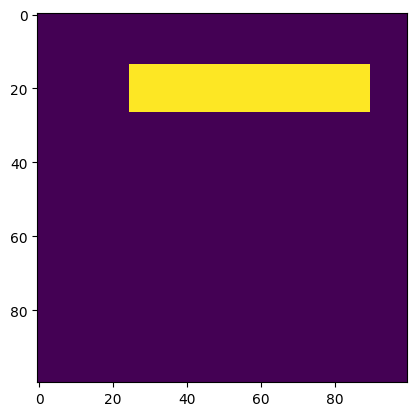

In [43]:
import matplotlib.pyplot as plt

plt.imshow(predicted_image[50, :, :] > 0)

In [40]:
2**3

8

In [4]:
import numpy as np

predicted_points = np.zeros((100, 100, 100))
for x in range(100):
    for y in range(100):
        for z in range(100):
            if z >= 25 and z < 90:
                if (x - 50) ** 2 + (y - 20) ** 2 <= 6:
                    predicted_points[x, y, z] = 1
x, y, z = np.where(predicted_points)
predicted_points = set(tuple(zip(x, y, z)))
print(predicted_points)

{(52, 20, 78), (52, 19, 33), (50, 20, 86), (51, 20, 53), (52, 21, 42), (48, 20, 29), (51, 21, 54), (52, 21, 78), (48, 21, 30), (49, 21, 54), (48, 19, 69), (50, 20, 63), (51, 20, 30), (51, 20, 66), (51, 21, 31), (52, 21, 55), (48, 20, 42), (49, 21, 31), (49, 20, 72), (50, 19, 75), (50, 20, 40), (48, 19, 82), (52, 20, 68), (51, 20, 43), (52, 21, 32), (50, 22, 85), (51, 22, 89), (51, 19, 83), (49, 19, 84), (50, 18, 87), (50, 19, 52), (48, 19, 59), (49, 20, 85), (52, 20, 45), (50, 19, 88), (50, 20, 53), (52, 20, 81), (52, 21, 45), (51, 19, 60), (50, 18, 64), (48, 19, 36), (49, 20, 62), (50, 19, 65), (50, 20, 30), (48, 19, 72), (52, 20, 58), (51, 20, 33), (51, 18, 72), (50, 22, 75), (51, 22, 79), (51, 19, 73), (49, 19, 74), (49, 20, 39), (50, 18, 77), (50, 19, 42), (48, 19, 49), (49, 20, 75), (52, 20, 35), (50, 21, 88), (50, 20, 43), (49, 22, 84), (50, 22, 52), (52, 19, 75), (51, 22, 56), (51, 18, 85), (51, 19, 50), (49, 18, 86), (49, 19, 51), (50, 22, 88), (50, 18, 54), (48, 19, 26), (49, 

In [11]:
import numpy as np
import scipy.spatial as spatial

tree = spatial.KDTree(
    np.column_stack([com_x[ids_to_keep], com_y[ids_to_keep], com_z[ids_to_keep]])
)
radius = 1000.0

neighbors = tree.query_ball_tree(tree, radius)
density = [len(n) for n in neighbors]
# print(neighbors)
# [[0, 1], [0, 1, 2], [1, 2], [3]]

In [15]:
density = np.array([len(n) for n in neighbors])
density.max()

117

In [ ]:
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np

frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/leaf-gall/jrc_22ak351-leaf-3m.n5/fragments_relabeled.csv"
)
id = frags["Object ID"]
com_x = frags["COM X (nm)"].to_numpy()
com_y = frags["COM Y (nm)"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy()
density = gaussian_kde(np.column_stack((com_x, com_y, com_z)).T)

In [ ]:
import numpy as np
from scipy import stats


def measure(n):
    "Measurement model, return two coupled measurements."
    m1 = np.random.normal(size=n)
    m2 = np.random.normal(scale=0.5, size=n)
    m3 = np.random.normal(size=n)
    return m1 + m2, m1 - m2, m3


m1, m2, m3 = measure(2000)
xmin = m1.min()
xmax = m1.max()
ymin = m2.min()
ymax = m2.max()
zmin = m3.min()
zmax = m3.max()

X, Y, Z = np.mgrid[xmin:xmax:100j, ymin:ymax:100j, zmin:zmax:100j]
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
values = np.vstack([m1, m2, m3])
kernel = stats.gaussian_kde(values)
Z = np.reshape(kernel(positions).T, X.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(
    np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax, zmin, zmax]
)
ax.plot(m1, m2, "k.", markersize=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])
plt.show()